Lecture 19: Sparse Autoencoders for MNIST classification
==

## Load Packages

In [8]:
%matplotlib inline
import copy
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.7.1


## Load Data:

In [9]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 1000

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

In [10]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is not available!


## Define the Sparse Autoencoder:

In [11]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(400, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)        
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

net = net.to(device)

init_weightsE = copy.deepcopy(net.encoder[0].weight.data)
init_weightsD = copy.deepcopy(net.decoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


## Train Autoencoder:

In [12]:
iterations = 20 # >10
learning_rate = 10
lambda1 = 0.1 # sparsity factor
criterion = nn.MSELoss()

dataiter = iter(testloader)
test_images, test_labels = dataiter.next()
printImg = torch.Tensor(int(iterations/10),2,1,28,28)

for epoch in range(iterations):  # loop over the dataset multiple times
    runningLoss = 0.0
    net.train()
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28*28).to(device)
        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, inputs) # calculate loss
        l1_norm = lambda1*torch.norm(net.encoder[0].weight, p=1) # L1 penalty for the encoder
        total_loss = loss+l1_norm        
        total_loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.item()
        
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))
    
    if epoch%10 == 0:
        net.eval()
        with torch.no_grad():
            outImg = net((test_images[0].view(-1,28*28).to(device))).data
            outImg = outImg.view(-1,28,28)
            if use_gpu:
                outImg = outImg.cpu()   

            dispImg = torch.Tensor(2,1,28,28)
            dispImg[0] = test_images[0]
            dispImg[1] = outImg
            printImg[int(epoch/10)] = dispImg
print('Finished Training')

At Iteration : 1 / 20  ;  Mean-Squared Error : 0.263630
At Iteration : 2 / 20  ;  Mean-Squared Error : 0.250976
At Iteration : 3 / 20  ;  Mean-Squared Error : 0.213383
At Iteration : 4 / 20  ;  Mean-Squared Error : 0.187284
At Iteration : 5 / 20  ;  Mean-Squared Error : 0.164493
At Iteration : 6 / 20  ;  Mean-Squared Error : 0.148327
At Iteration : 7 / 20  ;  Mean-Squared Error : 0.129430
At Iteration : 8 / 20  ;  Mean-Squared Error : 0.125743
At Iteration : 9 / 20  ;  Mean-Squared Error : 0.112250
At Iteration : 10 / 20  ;  Mean-Squared Error : 0.109304
At Iteration : 11 / 20  ;  Mean-Squared Error : 0.105521
At Iteration : 12 / 20  ;  Mean-Squared Error : 0.097920
At Iteration : 13 / 20  ;  Mean-Squared Error : 0.095285
At Iteration : 14 / 20  ;  Mean-Squared Error : 0.094876
At Iteration : 15 / 20  ;  Mean-Squared Error : 0.089349
At Iteration : 16 / 20  ;  Mean-Squared Error : 0.089718
At Iteration : 17 / 20  ;  Mean-Squared Error : 0.086397
At Iteration : 18 / 20  ;  Mean-Squared 

## Autoencoder Performance:

In [13]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

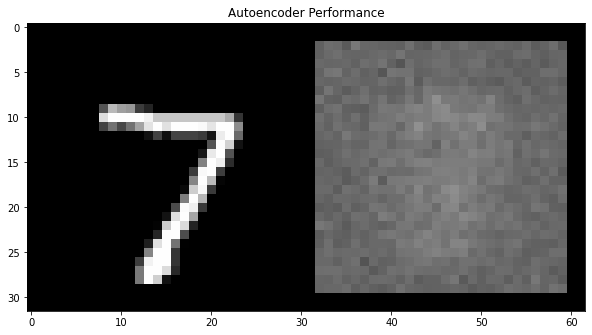

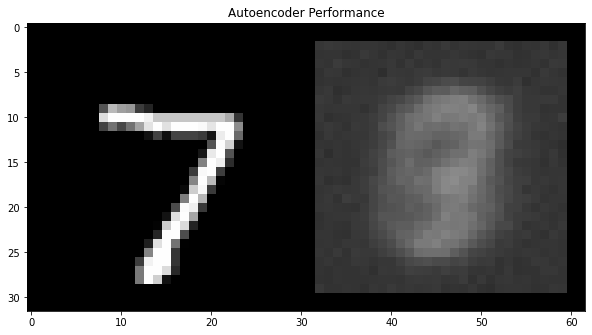

In [14]:
for i in range(int(iterations/10)):
    imshow(torchvision.utils.make_grid(printImg[i]), 'Autoencoder Performance')

## Encoder Weight Visualisation:

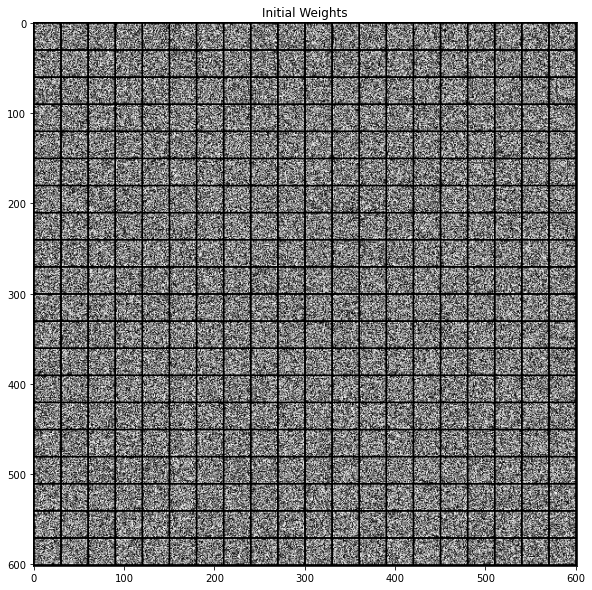

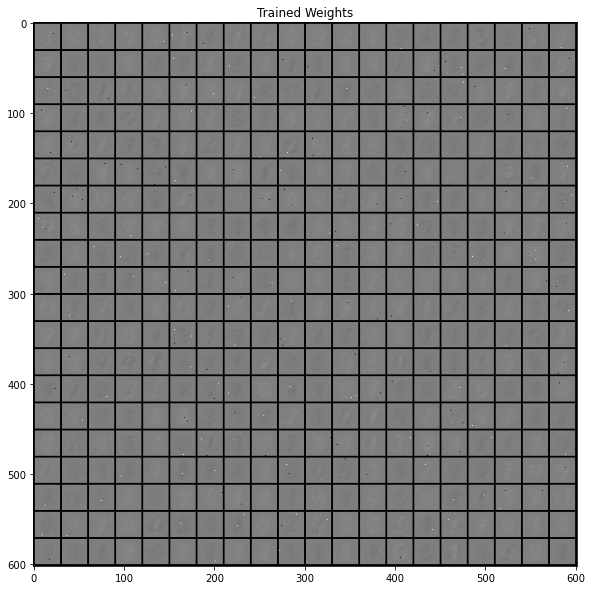

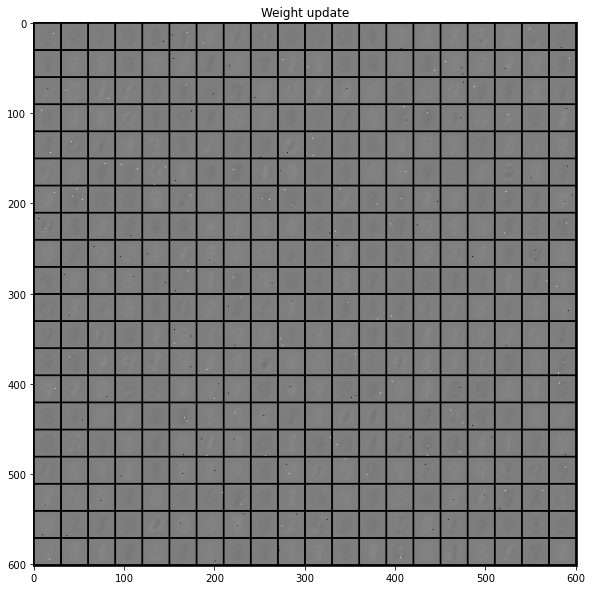

In [15]:
trained_weightsE = copy.deepcopy(net.encoder[0].weight.data)
d_weightsE = init_weightsE - trained_weightsE 

init_weightsE = init_weightsE.view(400,1,28,28)
trained_weightsE = trained_weightsE.view(400,1,28,28)
d_weightsE = d_weightsE.view(400,1,28,28)
if use_gpu:
    init_weightsE = init_weightsE.cpu()
    trained_weightsE = trained_weightsE.cpu()
    d_weightsE = d_weightsE.cpu()  

imshow(torchvision.utils.make_grid(init_weightsE,nrow=20,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weightsE,nrow=20,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weightsE,nrow=20,normalize=True), 'Weight update')

## Decoder Weight Visualisation:

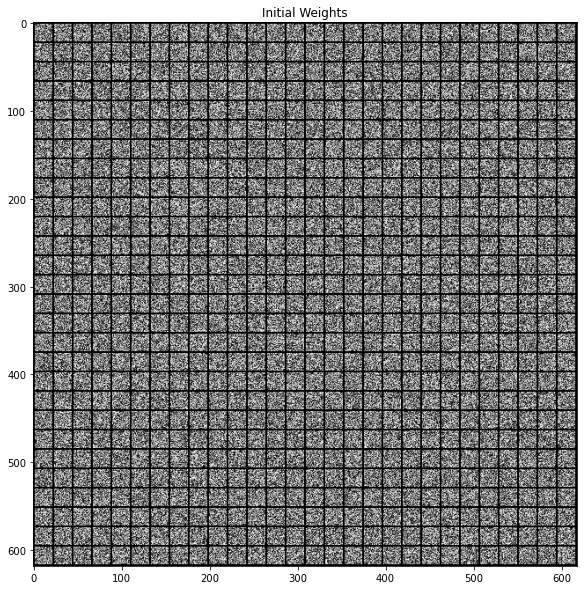

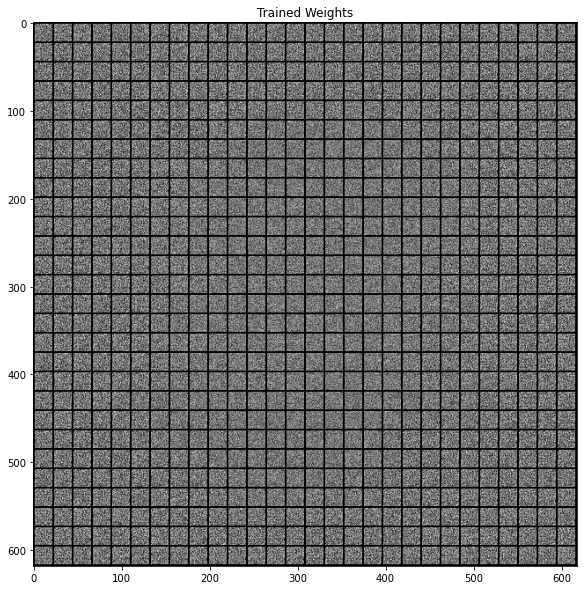

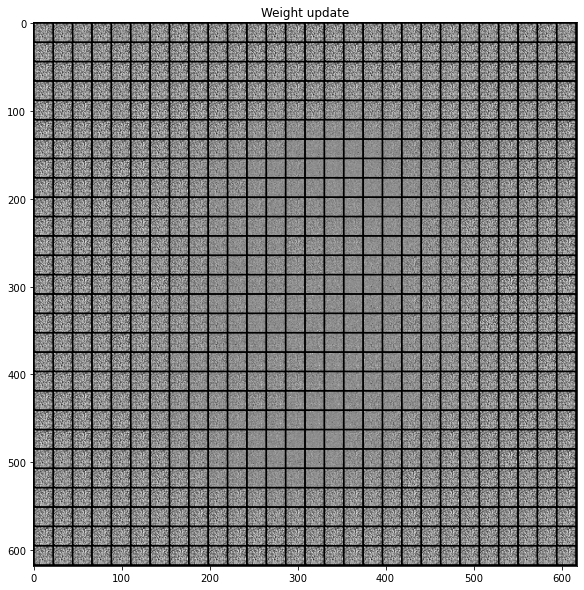

In [16]:
trained_weightsD = copy.deepcopy(net.decoder[0].weight.data)
d_weightsD = init_weightsD - trained_weightsD 

init_weightsD = init_weightsD.view(784,1,20,20)
trained_weightsD = trained_weightsD.view(784,1,20,20)
d_weightsD = d_weightsD.view(784,1,20,20)
if use_gpu:
    init_weightsD = init_weightsD.cpu()
    trained_weightsD = trained_weightsD.cpu()
    d_weightsD = d_weightsD.cpu()

imshow(torchvision.utils.make_grid(init_weightsD,nrow=28,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weightsD,nrow=28,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weightsD,nrow=28,normalize=True), 'Weight update')

## Modifying the autoencoder for classification: 

In [17]:
# Removing the decoder module from the autoencoder
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
# Adding linear layer for 10-class classification problem
net.add_module('classifier', nn.Sequential(nn.Linear(400, 10),nn.LogSoftmax(dim=1)))
print(net)
net = net.to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


## Train Classifier:

In [18]:
iterations = 10
learning_rate = 0.1
criterion = nn.NLLLoss()

for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    net.train()
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        
        inputs, labels = inputs.view(-1, 28*28).to(device), labels.to(device)

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.item()
        correct = 0
        total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.view(-1, 28*28).to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize),100 * float(correct) /float(total)))
print('Finished Training')

At Iteration : 1 / 10  ;  Train Error : 2.557520 ;Test Accuracy : 48.470000
At Iteration : 2 / 10  ;  Train Error : 1.235303 ;Test Accuracy : 69.560000
At Iteration : 3 / 10  ;  Train Error : 0.733115 ;Test Accuracy : 81.430000
At Iteration : 4 / 10  ;  Train Error : 0.534023 ;Test Accuracy : 88.720000
At Iteration : 5 / 10  ;  Train Error : 0.412151 ;Test Accuracy : 89.850000
At Iteration : 6 / 10  ;  Train Error : 0.374145 ;Test Accuracy : 90.300000
At Iteration : 7 / 10  ;  Train Error : 0.348120 ;Test Accuracy : 90.900000
At Iteration : 8 / 10  ;  Train Error : 0.329907 ;Test Accuracy : 91.360000
At Iteration : 9 / 10  ;  Train Error : 0.314937 ;Test Accuracy : 91.440000
At Iteration : 10 / 10  ;  Train Error : 0.302381 ;Test Accuracy : 91.860000
Finished Training


## Performance of different Classes:

In [19]:
class_correct = np.zeros(10)
class_total = np.zeros(10)
net.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.view(-1, 28*28).to(device))
        _, predicted = torch.max(outputs.data, 1)
        if use_gpu:
            predicted = predicted.cpu()        
        c = (predicted == labels).squeeze(0)        
        for i in range(images.shape[0]):
            label = labels[i]                            
            class_correct[label] += float(c[i])
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * float(class_correct[i]) / float(class_total[i])))

Accuracy of  zero : 98.367347 %
Accuracy of   one : 97.533040 %
Accuracy of   two : 88.178295 %
Accuracy of three : 92.277228 %
Accuracy of  four : 93.075356 %
Accuracy of  five : 84.529148 %
Accuracy of   six : 93.528184 %
Accuracy of seven : 91.634241 %
Accuracy of eight : 88.398357 %
Accuracy of  nine : 89.791873 %
